<a href="https://colab.research.google.com/github/komalsharmavlog/TheSparksFoundation/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

Saving RetailData.csv to RetailData.csv


In [4]:
#Import Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
Rtl_data = pd.read_csv('RetailData.csv', encoding = 'unicode_escape')
Rtl_data.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
#Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(541909, 8)

In [6]:
#Customer distribution by country
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [7]:
#Keep only United Kingdom data
Rtl_data = Rtl_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [8]:
#Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      133600
Country              0
dtype: int64

In [9]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()


-80995

In [10]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [11]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [12]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [13]:
#Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [14]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
Rtl_data.shape

(354345, 9)

In [15]:
Rtl_data.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


# RFM Modelling

In [17]:
#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
#Amount for each customer
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'ï»¿InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'ï»¿InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,22,103,4196.01
2,12748.0,4,4596,33719.73
3,12749.0,22,199,4090.88
4,12820.0,44,59,942.34


In [18]:
#Descriptive Statistics (Recency)
RFMScores.Recency.describe()

count    3921.000000
mean      104.586585
std       115.044919
min        -1.000000
25%        21.000000
50%        60.000000
75%       161.000000
max       696.000000
Name: Recency, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


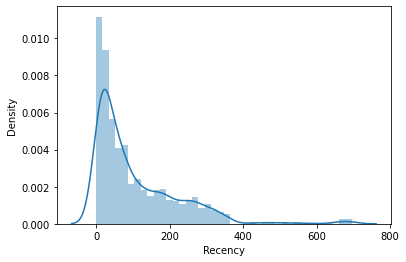

In [19]:
#Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

In [20]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [21]:
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89},
 'Recency': {0.25: 21.0, 0.5: 60.0, 0.75: 161.0}}

In [22]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [23]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,22,103,4196.01,2,1,1
12748.0,4,4596,33719.73,1,1,1
12749.0,22,199,4090.88,2,1,1
12820.0,44,59,942.34,2,2,2


In [24]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,22,103,4196.01,2,1,1,211,4
12748.0,4,4596,33719.73,1,1,1,111,3
12749.0,22,199,4090.88,2,1,1,211,4
12820.0,44,59,942.34,2,2,2,222,6


In [25]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,22,103,4196.01,2,1,1,211,4,Platinum
2,12748.0,4,4596,33719.73,1,1,1,111,3,Platinum
3,12749.0,22,199,4090.88,2,1,1,211,4,Platinum
4,12820.0,44,59,942.34,2,2,2,222,6,Gold


In [26]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,11,431,259657.30,1,1,1,111,3,Platinum
1,17450.0,2,337,194550.79,1,1,1,111,3,Platinum
2,17511.0,5,963,91062.38,1,1,1,111,3,Platinum
3,16684.0,11,277,66653.56,1,1,1,111,3,Platinum
4,14096.0,11,5111,65164.79,1,1,1,111,3,Platinum
5,15311.0,-1,2379,60767.90,1,1,1,111,3,Platinum
6,13089.0,5,1818,58825.83,1,1,1,111,3,Platinum
7,15061.0,4,403,54534.14,1,1,1,111,3,Platinum
8,14088.0,10,589,50491.81,1,1,1,111,3,Platinum
9,17841.0,-1,7847,40991.57,1,1,1,111,3,Platinum


In [29]:
!pip install chart_studio
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red', opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8   )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]
plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Recency Vs Monetary
graph = RFMScores.query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
  marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)



     |████████████████████████████████| 71kB 3.5MB/s 


# K-Means Clustering

In [31]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



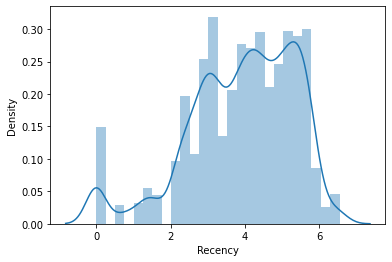

In [32]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



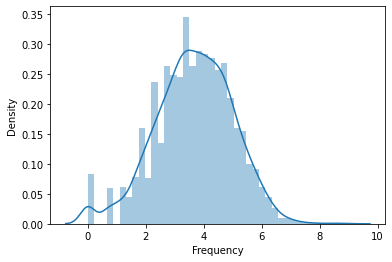

In [33]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



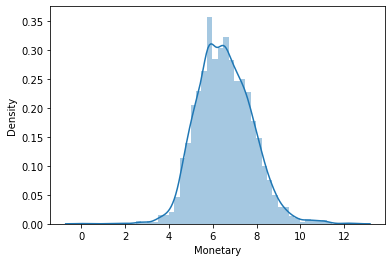

In [34]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [35]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

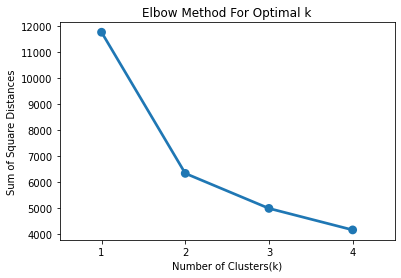

In [38]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,5):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [40]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 2, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0
12747.0,22,103,4196.01,2,1,1,211,4,Platinum,1
12748.0,4,4596,33719.73,1,1,1,111,3,Platinum,1
12749.0,22,199,4090.88,2,1,1,211,4,Platinum,1
12820.0,44,59,942.34,2,2,2,222,6,Gold,1


<Figure size 504x504 with 0 Axes>

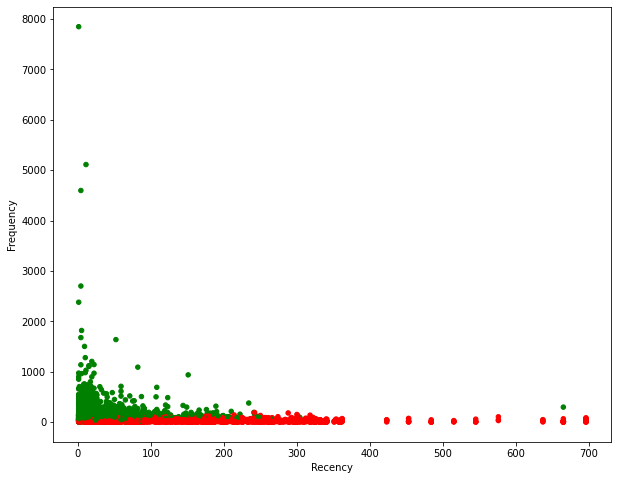

In [42]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)

In [43]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0,red
12747.0,22,103,4196.01,2,1,1,211,4,Platinum,1,green
12748.0,4,4596,33719.73,1,1,1,111,3,Platinum,1,green
12749.0,22,199,4090.88,2,1,1,211,4,Platinum,1,green
12820.0,44,59,942.34,2,2,2,222,6,Gold,1,green
